In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/Colab\ Notebooks/data

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/data


In [ ]:
!pip install kornia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import torch
import cv2
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import kornia as K
import kornia.feature as KF
import preprocessing
import validation
import plotting
import warnings
warnings.filterwarnings("ignore")
# directory of the training data
input_dir = './image-matching-challenge-2022/train'

In [ ]:
# Load all scene names from the training data
all_scenes = preprocessing.get_scenes(input_dir)
all_scenes 

['brandenburg_gate',
 'british_museum',
 'buckingham_palace',
 'colosseum_exterior',
 'grand_place_brussels',
 'lincoln_memorial_statue',
 'notre_dame_front_facade',
 'pantheon_exterior',
 'piazza_san_marco',
 'sacre_coeur',
 'sagrada_familia',
 'st_pauls_cathedral',
 'st_peters_square',
 'taj_mahal',
 'temple_nara_japan',
 'trevi_fountain']

In [ ]:
# Load all image pairs, along with their covisibility and fundamental matrix

#scenes = all_scenes # load all scenes
scenes = [all_scenes[0]] # load a specified scene

pairs = preprocessing.load_pairs(scenes,input_dir)

# Load either all pairs, or only withing a specific covisibility range
#pairs = pairs.reset_index() # load all pairs
#pairs = pairs.query('covisibility > 0.95').reset_index() # load pairs with a covisibility over a specified value
pairs = pairs.query('0.7 < covisibility < 0.8').reset_index() # load pairs within a covisibility range

loading category 1 of 1: brandenburg_gate


In [ ]:
# Determine if a GPU is available, otherwise use CPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
# Initialize LoFTR and load the outdoor weights
matcher = KF.LoFTR(pretrained='outdoor')
matcher = matcher.to(device).eval()

In [ ]:
# Run LoFTR on the image pairs loaded previously. The output is a DataFrame containing all relevant data for each image pair analyzed.
scene_list = []
fund_matrix_list = []
pair_list = []
fund_matrix_eval = []
pair_eval = []
mkpts0_list = []
mkpts1_list = []
mconf_list = []

for index, row in pairs.head(10).iterrows(): # Head controls how many image pairs are analyzed
    
    split_pair = pairs.pair[index].split('-')
    img_id0 = split_pair[0]
    img_id1 = split_pair[1]
    
    img0_pth = os.path.join(input_dir, pairs.scene[index], "images", str(img_id0 + '.jpg'))
    img1_pth = os.path.join(input_dir, pairs.scene[index], "images", str(img_id1 + '.jpg'))
    img0 = preprocessing.load_torch_image(img0_pth, device)
    img1 = preprocessing.load_torch_image(img1_pth, device)
    batch = {"image0": K.color.rgb_to_grayscale(img0), 
            "image1": K.color.rgb_to_grayscale(img1)}
    
    with torch.no_grad():
        matcher(batch)
        mkpts0 = batch['mkpts0_f'].cpu().numpy()
        mkpts1 = batch['mkpts1_f'].cpu().numpy()
        mconf = batch['mconf'].cpu().numpy()
        
    F = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.2, 0.99999, 50000)
    
    scene_list.append(pairs.scene[index])
    fund_matrix_list.append(F[0])
    pair_list.append(pairs.pair[index])
    fund_matrix_eval.append(" ".join(str(num) for num in F[0].flatten().tolist()))
    pair_eval.append(";".join(["phototourism",pairs.scene[index],pairs.pair[index]]))
    mkpts0_list.append(mkpts0)
    mkpts1_list.append(mkpts1)
    mconf_list.append(mconf)
    
results = pd.DataFrame({'scene': scene_list, 'pair': pair_list, 'fund_matrix': fund_matrix_list, 
                        'mkpts0': mkpts0_list, 'mkpts1': mkpts1_list, 'mconf': mconf_list,
                        'pair_eval': pair_eval, 'fund_matrix_eval': fund_matrix_eval}) 

In [ ]:
# Run the validation on all results and return the mean average accuracy
maa = validation.evaluate(input_dir, results.pair_eval, results.fund_matrix_eval)
print(f'mAA={maa} (n={len(results)})')

mAA=0.2899999999999999 (n=10)


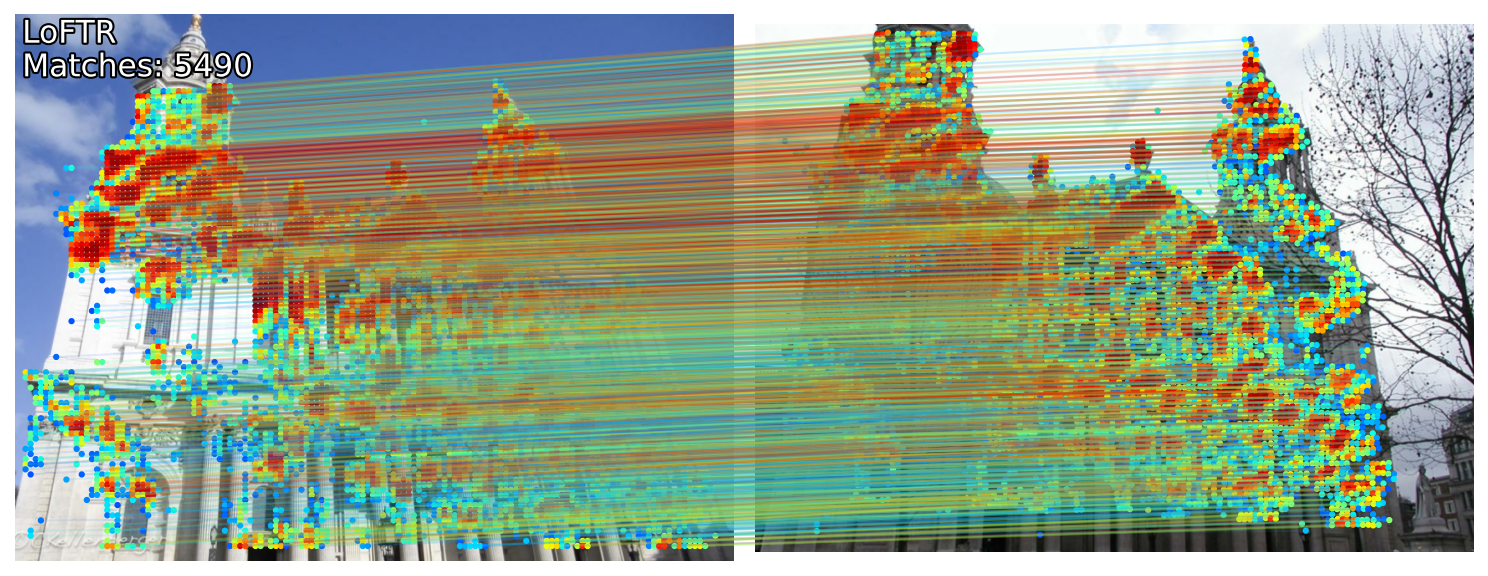

In [ ]:
# Draw matches for a single pair from the results

index = 7 # select image pair from results DataFrame
threshold = 0 # setting a confidence threshold between 0 and 1 (0 will plot all matches)

df_draw = pd.DataFrame({'mkpts0': results.mkpts0[index].tolist(), 'mkpts1': results.mkpts1[index].tolist(), 'mconf': results.mconf[index].tolist()})

img0_pth = os.path.join(input_dir, results.scene[index], "images", str(results.pair[index].split('-')[0] + '.jpg'))
img1_pth = os.path.join(input_dir, results.scene[index], "images", str(results.pair[index].split('-')[1] + '.jpg'))
img0 = preprocessing.load_image(img0_pth)
img1 = preprocessing.load_image(img1_pth)

color = cm.jet(df_draw.query(f'mconf > {threshold}').mconf)
text = [
    'LoFTR',
    'Matches: {}'.format(len(df_draw.query(f'mconf > {threshold}')))]
fig = plotting.make_matching_figure(img0, img1, np.array(df_draw.query(f'mconf > {threshold}').mkpts0.values.tolist()), 
                                    np.array(df_draw.query(f'mconf > {threshold}').mkpts1.values.tolist()), color, text=text, dpi=150, alpha = 0.1, lines = True)

In [ ]:
# Calculate the Fundamental Matrix for a single image match and perform evaluation
F = cv2.findFundamentalMat(np.array(df_draw.query(f'mconf > {threshold}').mkpts0.values.tolist()), np.array(df_draw.query(f'mconf > {threshold}').mkpts1.values.tolist()), cv2.USAC_MAGSAC, 0.2, 0.99999, 50000)
single_evaluate_scene = results.scene[index]
single_evaluate_pair = results.pair[index]
single_evaluate_pair_eval = results.pair_eval[index]
aa = validation.evaluate_single(input_dir, single_evaluate_pair_eval, " ".join(str(num) for num in F[0].flatten().tolist()))
print(f'Accuracy = {aa[0]}\nAngle error (degrees) = {aa[1][single_evaluate_scene][single_evaluate_pair]}\nDistance error (meters) = {aa[2][single_evaluate_scene][single_evaluate_pair]}')

Accuracy = 0.5
Angle error (degrees) = 0.5387292666175532
Distance error (meters) = 0.9149809993406111


### Plotting with Plotly instead of Matplotlib

Plotly can also be used to plot the matches, however lines can't be shown.

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


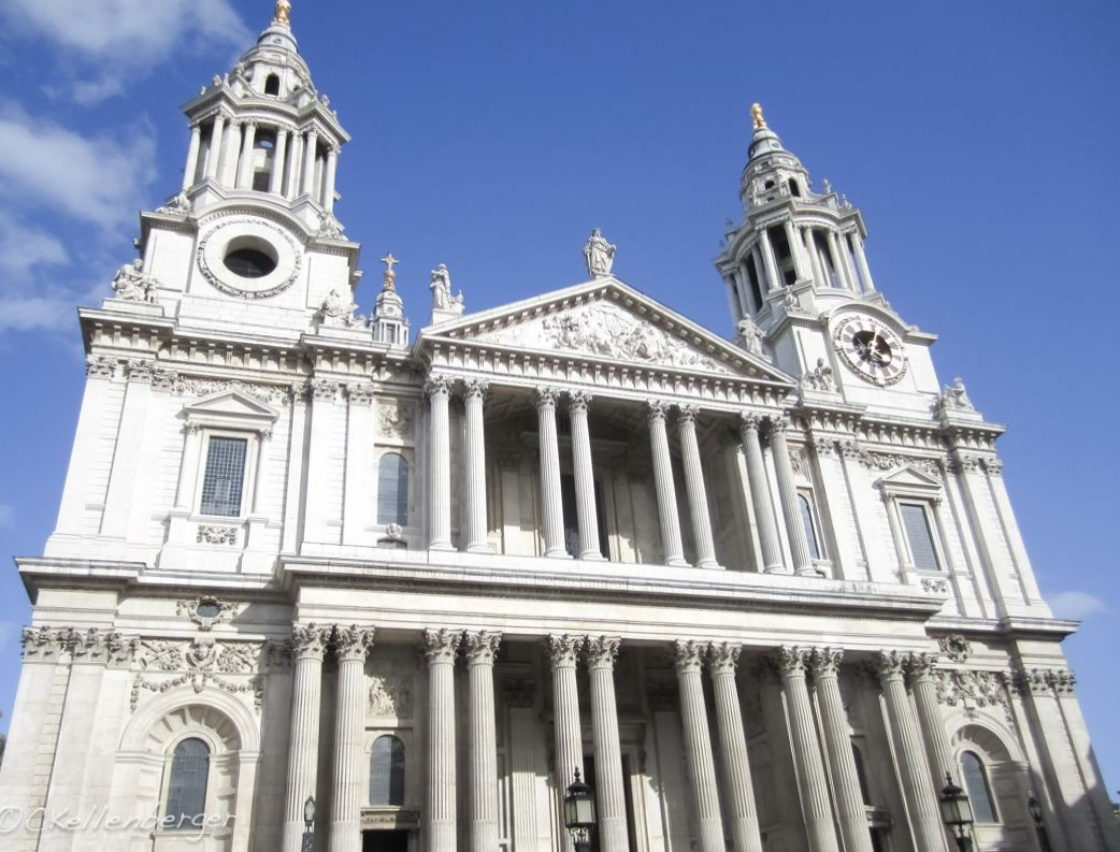
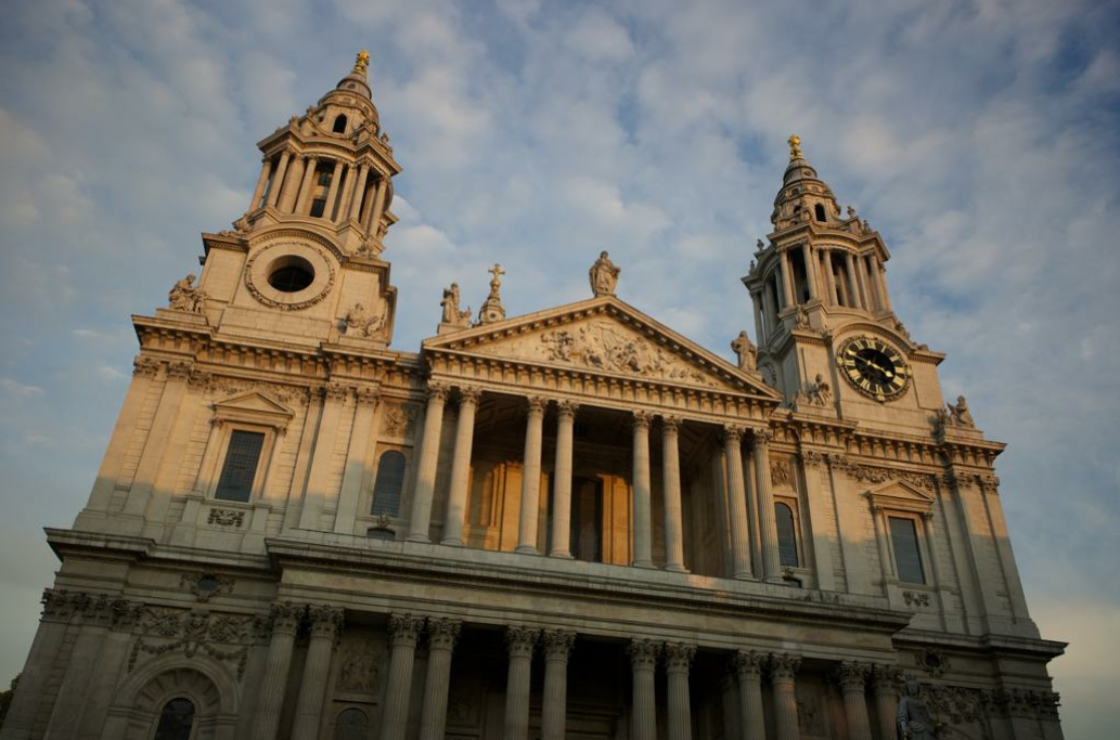

In [ ]:
# Draw matches for a single pair from the results with plotly (lines do not work)

index = 0 # select image pair from results DataFrame
threshold = 0 # setting a confidence threshold (0 == no threshold)

df_draw = pd.DataFrame({'mkpts0': results.mkpts0[index].tolist(), 'mkpts1': results.mkpts1[index].tolist(), 'mconf': results.mconf[index].tolist()})

img0_pth = os.path.join(input_dir, results.scene[index], "images", str(results.pair[index].split('-')[0] + '.jpg'))
img1_pth = os.path.join(input_dir, results.scene[index], "images", str(results.pair[index].split('-')[1] + '.jpg'))
img0 = preprocessing.load_image(img0_pth)
img1 = preprocessing.load_image(img1_pth)

color = cm.jet(df_draw.query(f'mconf > {threshold}').mconf)
color_trans = color * np.full(color.shape,255)
color_trans = np.delete(color_trans, -1, axis=1)
color_plotly = [f'rgb({",".join(c)})' for c in color_trans.astype(str)]
text = [
    'LoFTR',
    'Matches: {}'.format(len(df_draw.query(f'mconf > {threshold}')))]
fig = plotting.make_matching_figure_plotly(img0, img1, np.array(df_draw.query(f'mconf > {threshold}').mkpts0.values.tolist()), 
                                    np.array(df_draw.query(f'mconf > {threshold}').mkpts1.values.tolist()), color_plotly, text=text, alpha = 0.1)
fig

### Outlier removal using DBSCAN

We tried to improve LoFTR accuracy by removing outliers in the matched points with DBSCAN. However, this resulted in reduced accuracy for most image pairs, so we didn't include DBSCAN in our final model.

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

In [ ]:
# Take matched points for the left image and append the corresponding confidence values for each point
X = results.mkpts0[index]
X_conf = results.mconf[index]
X_conf_reshaped = np.reshape(X_conf, (len(X), 1))
X_concat = np.append(X, X_conf_reshaped, axis = 1)

In [ ]:
# Scaling everything to values between 0 and 1
scaler = MinMaxScaler()
X_concat_scaled = scaler.fit_transform(X_concat)

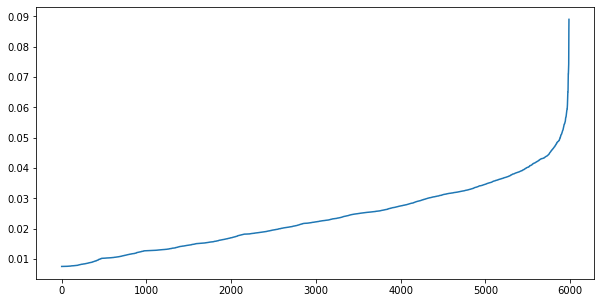

In [ ]:
# Plotting the "Elbow" to find the optimal DBSCAN epsilon value. Usually 0.05-0.06 for our model.
plt.figure(figsize=(10,5))
nn = NearestNeighbors(n_neighbors=5).fit(X_concat_scaled)
distances, idx = nn.kneighbors(X_concat_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.show()

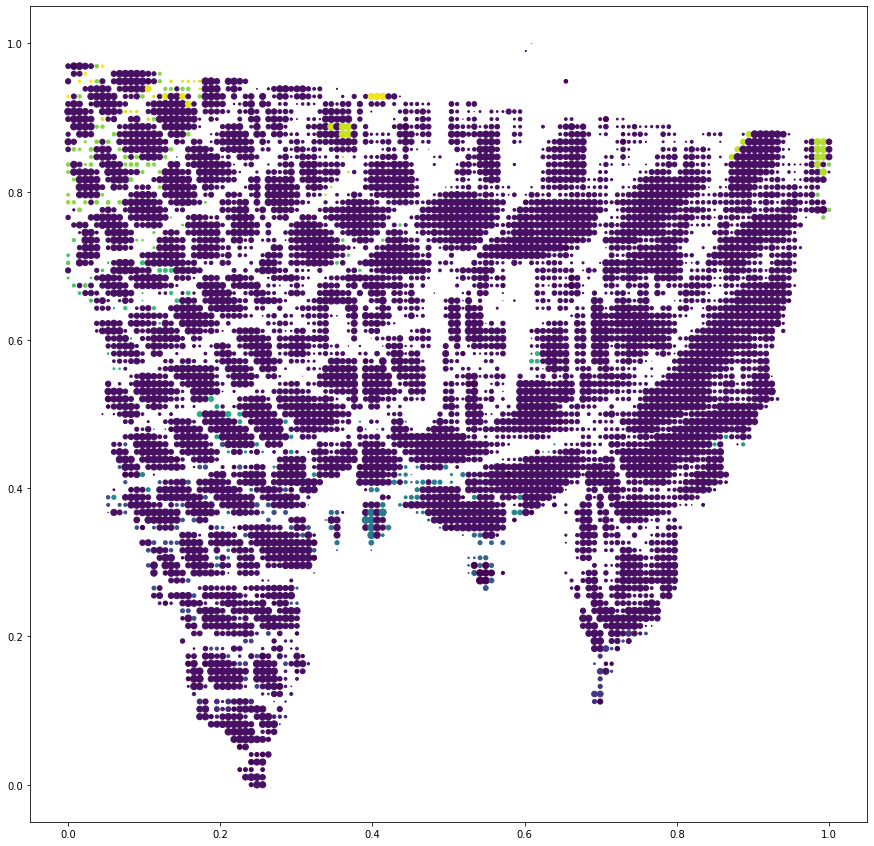

In [ ]:
# Performing DBSCAN and plotting the resulting clusters
clustering = DBSCAN(eps=0.05, min_samples=3).fit(X_concat_scaled)
plt.figure(figsize=(15,15))
plt.scatter(X_concat_scaled[:, 0], X_concat_scaled[:, 1], c = clustering.labels_, s = X_concat_scaled[:,2]*50)

In [ ]:
# Evaluating the image match while excluding the points classified as outliers/noise
df_draw['clustering_labels'] = clustering.labels_

F = cv2.findFundamentalMat(np.array(df_draw.query(f'clustering_labels != -1').mkpts0.values.tolist()), np.array(df_draw.query(f'clustering_labels != -1').mkpts1.values.tolist()), cv2.USAC_MAGSAC, 0.2, 0.99999, 50000)
single_evaluate_scene = results.scene[index]
single_evaluate_pair = results.pair[index]
single_evaluate_pair_eval = results.pair_eval[index]
aa = validation.evaluate_single(input_dir, single_evaluate_pair_eval, " ".join(str(num) for num in F[0].flatten().tolist()))
print(f'Accuracy = {aa[0]}\nAngle error (degrees) = {aa[1][single_evaluate_scene][single_evaluate_pair]}\nDistance error (meters) = {aa[2][single_evaluate_scene][single_evaluate_pair]}')

Accuracy = 0.3
Angle error (degrees) = 2.3162458022333094
Distance error (meters) = 2.2357794461858393
